# TP OpenMP - October 2022
## Part 1 : Pi
### Compilation

In [7]:
!g++ -o ./exe_bin/tp_openmp_part_1_pi_sequential ./Part_1/tp_openmp_part_1_pi_sequential.cpp -fopenmp -O3 -march=native
!g++ -o ./exe_bin/tp_openmp_part_1_pi_impl_reduce ./Part_1/tp_openmp_part_1_pi_impl_reduce.cpp -fopenmp -O3 -march=native
!g++ -o ./exe_bin/tp_openmp_part_1_pi_impl_atomic ./Part_1/tp_openmp_part_1_pi_impl_atomic.cpp -fopenmp -O3 -march=native
!g++ -o ./exe_bin/tp_openmp_part_1_pi_impl_critical ./Part_1/tp_openmp_part_1_pi_impl_critical.cpp -fopenmp -O3 -march=native
!g++ -o ./exe_bin/tp_openmp_part_1_pi_impl_split_array ./Part_1/tp_openmp_part_1_pi_impl_split_array.cpp -fopenmp -O3 -march=native

### Performance evaluation

In [8]:
import os
import subprocess
import re

try:
    os.remove("stats.csv")
except OSError:
    pass

num_steps = [1000, 1000000]#, 100000000, 10000000000, 1000000000000]
nb_core = [1, 2, 4, 8, 16, 32, 64]
repeats = range(0,10)
executables = ['tp_openmp_part_1_pi_sequential', 'tp_openmp_part_1_pi_impl_reduce', 'tp_openmp_part_1_pi_impl_atomic', 'tp_openmp_part_1_pi_impl_critical', 'tp_openmp_part_1_pi_impl_split_array']

for nsteps in num_steps:
    for ncore in nb_core:
        for repeat in repeats:
            for executable in executables:
                args = ("./exe_bin/" + executable, "-C", str(ncore), "-N", str(nsteps))
                popen = subprocess.Popen(args, stdout=subprocess.PIPE)
                popen.wait()

                try:
                    out, err = popen.communicate(timeout=1)
                except Exception:
                    out = b''
                if isinstance(out, bytes):
                    out = out.decode(errors='ignore')

                m = re.search(r'pi with\s+(\d+)\s+steps is\s+([0-9.+-eE]+)\s+in\s+([0-9.+-eE]+)\s+seconds', out)
                if m:
                    pi_val = m.group(2)
                    time_s = m.group(3)
                else:
                    # fallback: use last non-empty line of stdout
                    lines = [ln.strip() for ln in out.splitlines() if ln.strip()]
                    last = lines[-1] if lines else ''
                    pi_val = ''
                    time_s = ''
                    # try to extract numbers from last line if possible
                    m2 = re.search(r'([0-9.+-eE]+).*in.*([0-9.+-eE]+)\s*seconds', last)
                    if m2:
                        pi_val = m2.group(1)
                        time_s = m2.group(2)

                # one-line summary
                # print(f"{executable} | cores={ncore} | steps={nsteps} | repeat={repeat} | rc={popen.returncode} | pi={pi_val} | time_s={time_s}")
                csv_path = './Part_1/stats.csv'
                with open(csv_path, 'a') as fh:
                    fh.write(f"{executable},{ncore},{nsteps},{time_s}\n")



### Performance analysis
#### Weak scaling

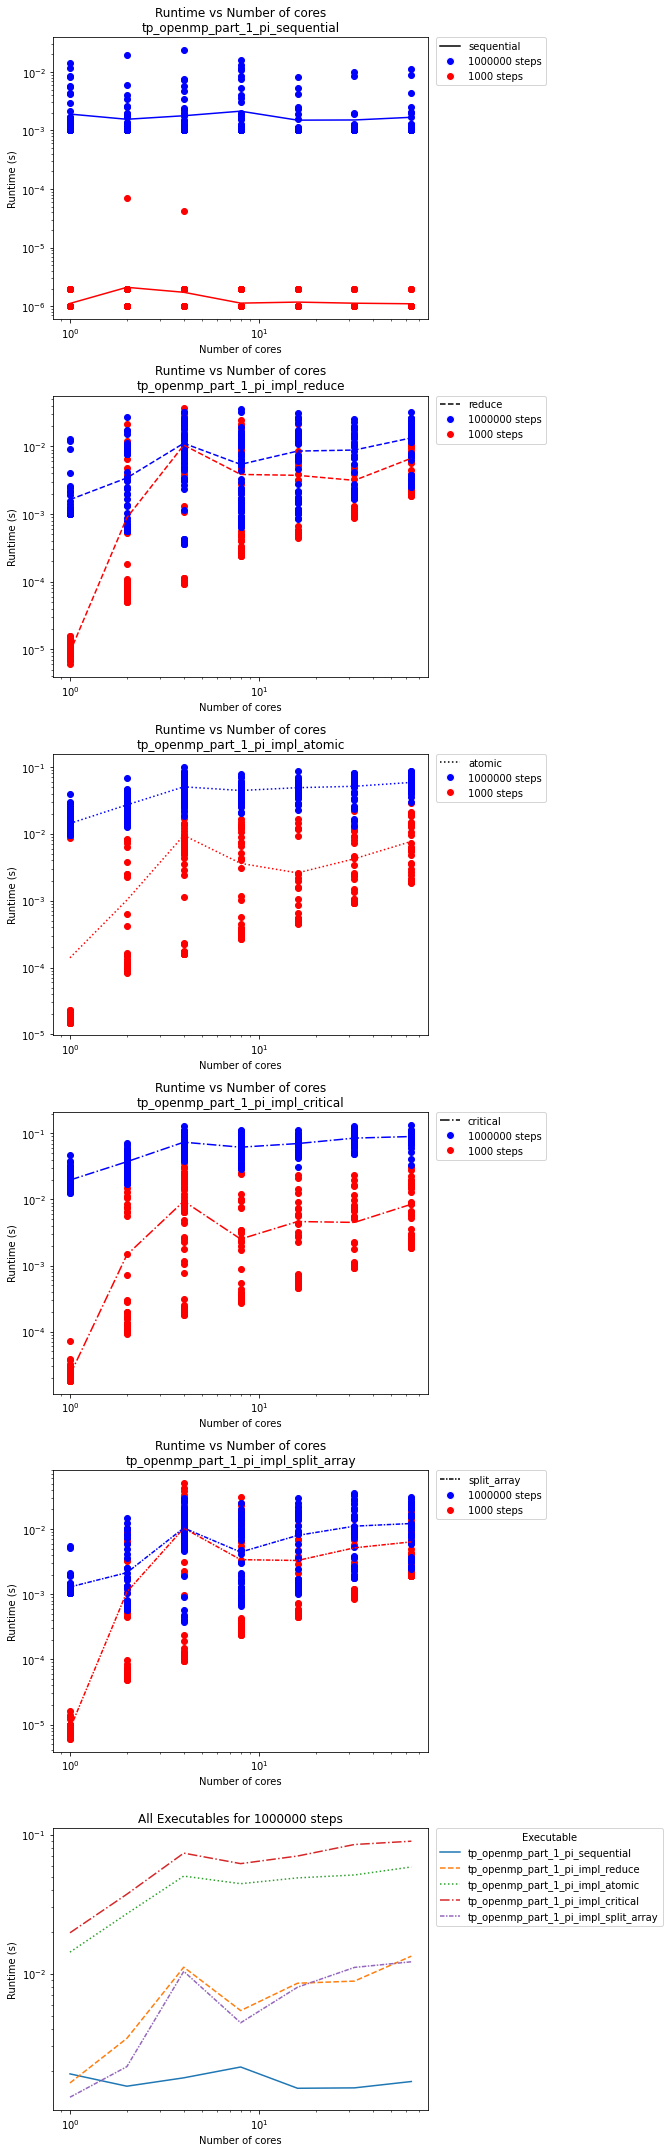

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Lecture du fichier CSV
df = pd.read_csv('./Part_1/stats.csv', header=None, names=['version','nbcore','num_steps','runtime'], dtype={
                     'version': str,
                     'nbcore': int,
                     'num_steps' : int,
                     'runtime' : float
                 })

color_num_steps = {1000000 : "blue", 1000 : "red"}

# Nombre de subplots à créer : un pour chaque exécutable, cette fois disposés verticalement
fig, axes = plt.subplots(nrows=len(executables) + 1, ncols=1, figsize=(8, 5 * (len(executables) + 1)))

# Si il n'y a qu'un seul subplot (si executables ne contient qu'un seul élément)
if len(executables) == 1:
    axes = [axes]

# Style des lignes pour les différents exécutables
linestyles = ['solid', 'dashed', 'dotted', 'dashdot', (0, (3, 1, 1, 1))]  # fallback styles pour jusqu'à 5 exécutables

# Tracer les courbes pour chaque exécutable dans son subplot respectif
for idx, executable in enumerate(executables):
    ax = axes[idx]  # Sélectionner le subplot correspondant à l'exécutable
    for num_steps in sorted(df['num_steps'].unique()):
        df_plot = df[(df['num_steps'] == int(num_steps)) & (df['version'] == executable)]
        if df_plot.empty:
            continue
        mean_stats = df_plot.groupby(['num_steps', 'version', 'nbcore']).mean().reset_index()
        ls = linestyles[idx] if idx < len(linestyles) else 'solid'
        ax.plot(mean_stats['nbcore'], mean_stats['runtime'], linestyle=ls, color=color_num_steps[int(num_steps)])
        ax.scatter(df_plot['nbcore'], df_plot['runtime'], color=color_num_steps[int(num_steps)])

    # Définir l'échelle des axes et les labels pour chaque subplot
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of cores')
    ax.set_ylabel('Runtime (s)')
    ax.set_title(f'Runtime vs Number of cores\n{executable}')

    # Ajouter des légendes spécifiques pour cet exécutable
    num_steps_patches = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label=f'{n} steps')
        for n, color in color_num_steps.items()
    ]
    version_handles = [
        plt.Line2D([0], [0], linestyle=ls, color='black', label=executable.replace('tp_openmp_part_1_pi_impl_', '').replace('tp_openmp_part_1_pi_', ''))
    ]

    ax.legend(handles=version_handles + num_steps_patches, loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

# Ajouter un graphe avec tous les exécutables pour num_steps=1000000
ax_all_executables = axes[-1]  # Le dernier subplot

for executable in executables:
    df_plot = df[(df['num_steps'] == 1000000) & (df['version'] == executable)]
    if df_plot.empty:
        continue
    mean_stats = df_plot.groupby(['num_steps', 'version', 'nbcore']).mean().reset_index()
    ls = linestyles[executables.index(executable)] if executables.index(executable) < len(linestyles) else 'solid'
    ax_all_executables.plot(mean_stats['nbcore'], mean_stats['runtime'], linestyle=ls, label=executable)

# Définir l'échelle des axes et les labels pour le graphique global
ax_all_executables.set_xscale('log')
ax_all_executables.set_yscale('log')
ax_all_executables.set_xlabel('Number of cores')
ax_all_executables.set_ylabel('Runtime (s)')
ax_all_executables.set_title('All Executables for 1000000 steps')

# Ajouter une légende pour le graphique global
ax_all_executables.legend(title='Executable', loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

# Ajuster l'agencement des subplots
plt.tight_layout()
plt.subplots_adjust(right=0.75)
plt.show()


### Discussion

Parfois quand on essaie de paralleliser alors qu'on n'a pas assez de calcul pour que ca soit rentable on commence a voir les performances se deteriorer notamment pour le premier graphe pour n = 3 qu'on passe de 4 a 6 coeurs on a le temps d'execution qui augmente car ....

## Part 2 : Matrix-Vector Operation
### Compilation


In [11]:
!g++ -o ./exe_bin/tp_openmp_part_2_vector_openmp ./Part_2/tp_openmp_part_2_vector_openmp.cpp -fopenmp -O3 -march=native
!g++ -o ./exe_bin/tp_openmp_part_2_vector_sequential ./Part_2/tp_openmp_part_2_vector_sequential.cpp -fopenmp -O3 -march=native
!g++ -o ./exe_bin/tp_openmp_part_2_vector_simd ./Part_2/tp_openmp_part_2_vector_simd.cpp -fopenmp -O3 -march=native

### Performance evaluation

In [12]:
import os
import subprocess
import re

try:
    os.remove("stats.csv")
except OSError:
    pass

N = [2, 4, 8]#, 10, 12, 14, 16]
M = [1, 3, 7]#, 9, 11, 13, 15]
nb_core = [1, 2, 4, 8, 16, 32, 64]
repeats = range(0,10)
executables = ['tp_openmp_part_2_vector_openmp', 'tp_openmp_part_2_vector_sequential', 'tp_openmp_part_2_vector_simd']

for n in N:
    for m in M:
        for ncore in nb_core:
            for repeat in repeats:
                for executable in executables:
                    args = ("./exe_bin/" + executable, "-T", str(ncore), "-N", str(n), "-M", str(m))
                    popen = subprocess.Popen(args, stdout=subprocess.PIPE)
                    popen.wait()

                    try:
                        out, err = popen.communicate(timeout=1)
                    except Exception:
                        out = b''
                    if isinstance(out, bytes):
                        out = out.decode(errors='ignore')

                    # extraire uniquement le temps (en secondes) depuis la sortie
                    lines = [ln.strip() for ln in out.splitlines() if ln.strip()]
                    last = lines[-1] if lines else ''
                    time_s = ''

                    # priorité 1: time(...) présent dans la sortie
                    m_time = re.search(r'time\(\s*([0-9.+-eE]+)\s*s', out, flags=re.IGNORECASE)
                    if m_time:
                        time_s = m_time.group(1)
                    else:
                        # fallback 1: "in X seconds"
                        m_time2 = re.search(r'in\s+([0-9.+-eE]+)\s+seconds', out, flags=re.IGNORECASE)
                        if m_time2:
                            time_s = m_time2.group(1)
                        else:
                            # fallback final: dernier nombre flottant sur la dernière ligne non vide
                            m3 = re.findall(r'([0-9.+-eE]+)', last)
                            time_s = m3[-1] if m3 else ''

                    # one-line summary
                    # print(f"{executable} | cores={ncore} | steps={nsteps} | repeat={repeat} | rc={popen.returncode} | pi={pi_val} | time_s={time_s}")
                    csv_path = './Part_2/stats.csv'
                    with open(csv_path, 'a') as fh:
                        fh.write(f"{executable},{ncore},{n},{m},{time_s}\n")



### Performance analysis
#### Weak scaling

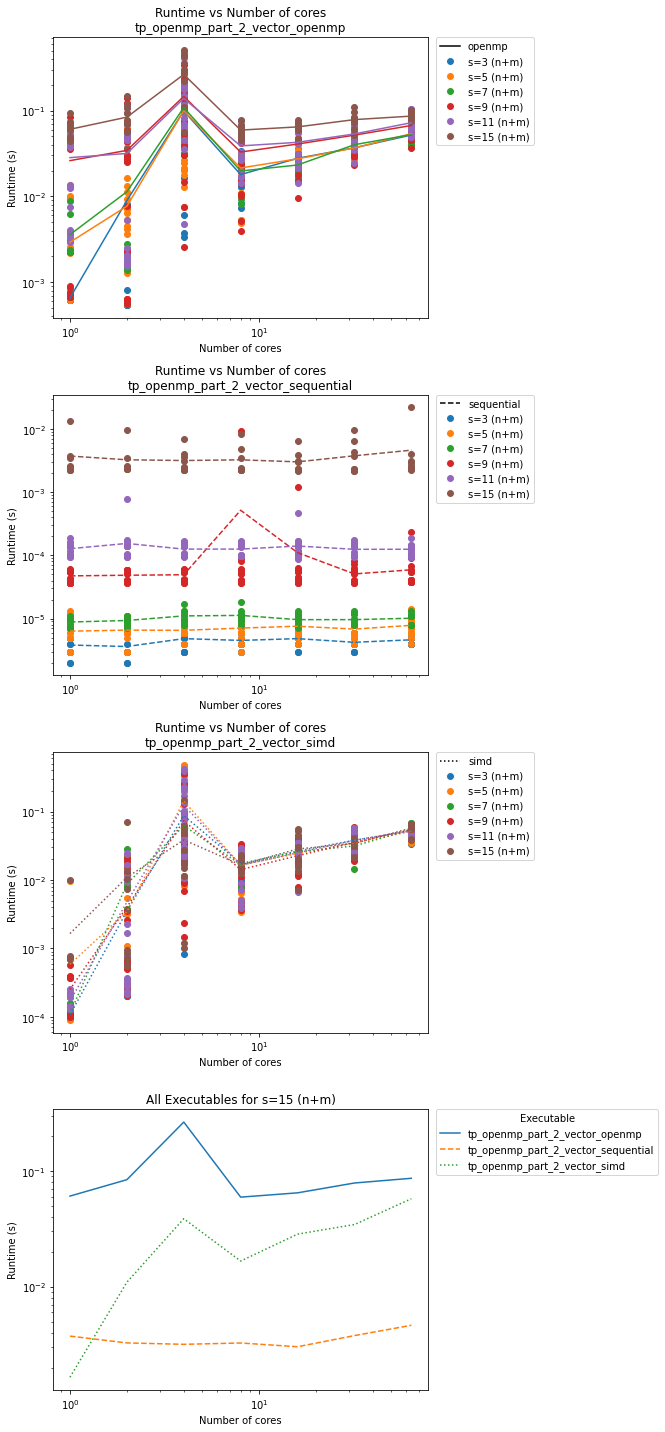

In [ ]:
# Lecture du fichier CSV Part 2 (format: executable,ncore,n,m,runtime)
df = pd.read_csv('./Part_2/stats.csv', header=None,
                 names=['version','nbcore','n','m','runtime'],
                 dtype={'version': str, 'nbcore': int, 'n': int, 'm': int, 'runtime': float})

# nouvelle colonne s = n + m
df['s'] = df['n'] + df['m']

# mapping de couleurs pour chaque valeur de s
unique_s = sorted(df['s'].unique())
cmap = plt.get_cmap('tab10')
colors_s = {s: cmap(i % cmap.N) for i, s in enumerate(unique_s)}

# subplots : un par exécutable + un dernier récapitulatif
fig, axes = plt.subplots(nrows=len(executables) + 1, ncols=1, figsize=(8, 5 * (len(executables) + 1)))
if len(executables) == 1:
    axes = [axes]

linestyles = ['solid', 'dashed', 'dotted', 'dashdot', (0, (3, 1, 1, 1))]

for idx, executable in enumerate(executables):
    ax = axes[idx]
    for s in unique_s:
        df_plot = df[(df['s'] == s) & (df['version'] == executable)]
        if df_plot.empty:
            continue
        mean_stats = df_plot.groupby(['s', 'version', 'nbcore']).mean().reset_index()
        ls = linestyles[idx] if idx < len(linestyles) else 'solid'
        ax.plot(mean_stats['nbcore'], mean_stats['runtime'], linestyle=ls, color=colors_s[s])
        ax.scatter(df_plot['nbcore'], df_plot['runtime'], color=colors_s[s])

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of cores')
    ax.set_ylabel('Runtime (s)')
    ax.set_title(f'Runtime vs Number of cores\n{executable}')

    # légende par valeur de s
    s_patches = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_s[s], markersize=8, label=f's={s} (n+m)')
        for s in unique_s
    ]
    version_handle = plt.Line2D([0], [0], linestyle=ls, color='black',
                                label=executable.replace('tp_openmp_part_2_vector_', ''))
    ax.legend(handles=[version_handle] + s_patches, loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

# dernier subplot : tracer tous les exécutables pour une valeur de s choisie (ici la plus grande s)
ax_all_executables = axes[-1]
s_to_plot = unique_s[-1] if unique_s else None

if s_to_plot is not None:
    for executable in executables:
        df_plot = df[(df['s'] == s_to_plot) & (df['version'] == executable)]
        if df_plot.empty:
            continue
        mean_stats = df_plot.groupby(['s', 'version', 'nbcore']).mean().reset_index()
        ls = linestyles[executables.index(executable)] if executables.index(executable) < len(linestyles) else 'solid'
        ax_all_executables.plot(mean_stats['nbcore'], mean_stats['runtime'], linestyle=ls, label=executable)

    ax_all_executables.set_xscale('log')
    ax_all_executables.set_yscale('log')
    ax_all_executables.set_xlabel('Number of cores')
    ax_all_executables.set_ylabel('Runtime (s)')
    ax_all_executables.set_title(f'All Executables for s={s_to_plot} (n+m)')
    ax_all_executables.legend(title='Executable', loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

plt.tight_layout()
plt.subplots_adjust(right=0.75)
plt.show()


## Part 3 : Fibonacci and linked lists
### Compilation

In [1]:
!g++ -o ./exe_bin/tp_openmp_part_3_fib_openmp ./Part_3/tp_openmp_part_3_fib_openmp.cpp -fopenmp -O3 -march=native
!g++ -o ./exe_bin/tp_openmp_part_3_fib_sequential ./Part_3/tp_openmp_part_3_fib_sequential.cpp -fopenmp -O3 -march=native

### Performance evaluation

In [2]:
import os
import subprocess
import re

try:
    os.remove("stats.csv")
except OSError:
    pass

N = [3, 5]#, 15, 20, 25, 30, 35, 40]
nb_core = [1, 2, 4, 8]#, 16, 32, 64]
repeats = range(0,10)
executables = ['tp_openmp_part_3_fib_openmp', 'tp_openmp_part_3_fib_sequential']

for n in N:
    for ncore in nb_core:
        for repeat in repeats:
            for executable in executables:
                args = ("./exe_bin/" + executable, "-T", str(ncore), "-N", str(n))
                popen = subprocess.Popen(args, stdout=subprocess.PIPE)
                popen.wait()

                try:
                    out, err = popen.communicate(timeout=1)
                except Exception:
                    out = b''
                if isinstance(out, bytes):
                    out = out.decode(errors='ignore')

                # extraire uniquement le temps (en secondes) depuis la sortie
                lines = [ln.strip() for ln in out.splitlines() if ln.strip()]
                last = lines[-1] if lines else ''
                time_s = ''

                # priorité 1: "Compute Time: 0.123456 seconds" présent dans la sortie
                m_time = re.search(r'Compute\s+Time:\s*([0-9.+-eE]+)\s*seconds', out, flags=re.IGNORECASE)
                if m_time:
                    time_s = m_time.group(1)
                else:
                    # fallback 1: "in X seconds"
                    m_time2 = re.search(r'in\s+([0-9.+-eE]+)\s+seconds', out, flags=re.IGNORECASE)
                    if m_time2:
                        time_s = m_time2.group(1)
                    else:
                        # fallback final: dernier nombre flottant sur la dernière ligne non vide
                        m3 = re.findall(r'([0-9.+-eE]+)', last)
                        time_s = m3[-1] if m3 else ''

                # one-line summary
                # print(f"{executable} | cores={ncore} | steps={nsteps} | repeat={repeat} | rc={popen.returncode} | pi={pi_val} | time_s={time_s}")
                csv_path = './Part_3/stats.csv'
                with open(csv_path, 'a') as fh:
                    fh.write(f"{executable},{ncore},{n},{time_s}\n")



### Performance analysis
#### Weak scaling

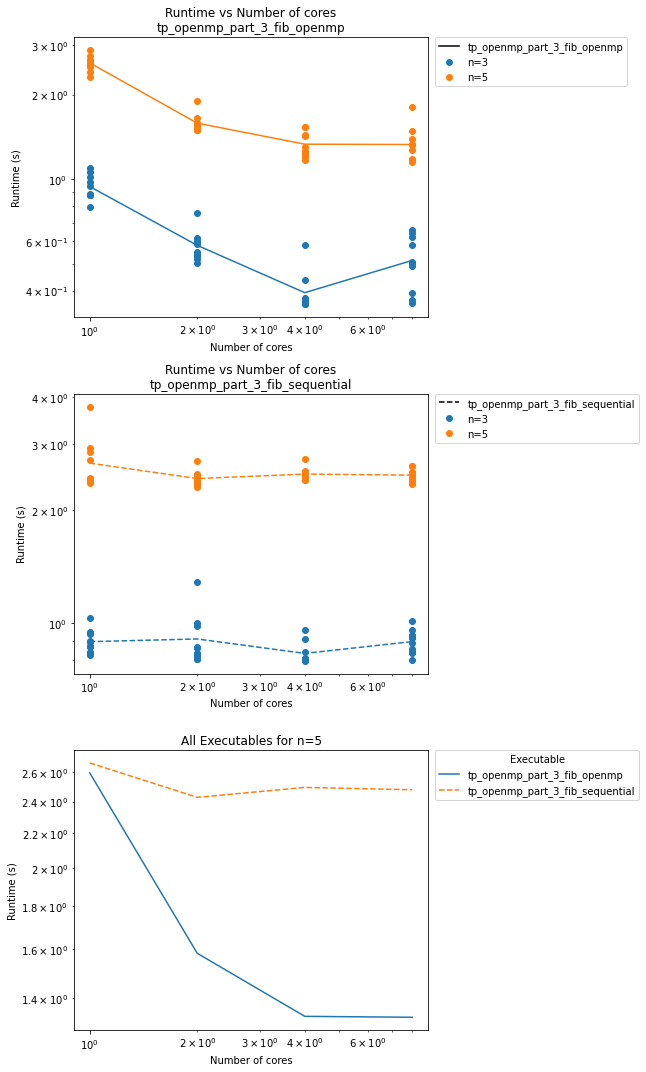

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Lecture du fichier CSV Part 2 (format: executable,ncore,n,m,runtime)
df = pd.read_csv('./Part_3/stats.csv', header=None,
                 names=['version', 'nbcore', 'n', 'runtime'],
                 dtype={'version': str, 'nbcore': int, 'n': int, 'runtime': float})

# Mapping de couleurs pour chaque valeur de n (et non plus de s)
unique_n = sorted(df['n'].unique())  # utiliser 'n' à la place de 's'
cmap = plt.get_cmap('tab10')
colors_n = {n: cmap(i % cmap.N) for i, n in enumerate(unique_n)}

# Subplots : un par exécutable + un dernier récapitulatif
fig, axes = plt.subplots(nrows=len(executables) + 1, ncols=1, figsize=(8, 5 * (len(executables) + 1)))
if len(executables) == 1:
    axes = [axes]

linestyles = ['solid', 'dashed', 'dotted', 'dashdot', (0, (3, 1, 1, 1))]

for idx, executable in enumerate(executables):
    ax = axes[idx]
    for n in unique_n:  # Remplacer 's' par 'n' ici
        df_plot = df[(df['n'] == n) & (df['version'] == executable)]  # Filtrer par 'n' et 'executable'
        if df_plot.empty:
            continue
        mean_stats = df_plot.groupby(['n', 'version', 'nbcore']).mean().reset_index()
        ls = linestyles[idx] if idx < len(linestyles) else 'solid'
        ax.plot(mean_stats['nbcore'], mean_stats['runtime'], linestyle=ls, color=colors_n[n])
        ax.scatter(df_plot['nbcore'], df_plot['runtime'], color=colors_n[n])

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of cores')
    ax.set_ylabel('Runtime (s)')
    ax.set_title(f'Runtime vs Number of cores\n{executable}')

    # Légende par valeur de n
    n_patches = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_n[n], markersize=8, label=f'n={n}')
        for n in unique_n
    ]
    version_handle = plt.Line2D([0], [0], linestyle=ls, color='black',
                                label=executable.replace('tp_openmp_part_2_vector_', ''))
    ax.legend(handles=[version_handle] + n_patches, loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

# Dernier subplot : tracer tous les exécutables pour une valeur de n choisie (ici la plus grande n)
ax_all_executables = axes[-1]
n_to_plot = unique_n[-1] if unique_n else None

if n_to_plot is not None:
    for executable in executables:
        df_plot = df[(df['n'] == n_to_plot) & (df['version'] == executable)]  # Filtrer par 'n' ici
        if df_plot.empty:
            continue
        mean_stats = df_plot.groupby(['n', 'version', 'nbcore']).mean().reset_index()
        ls = linestyles[executables.index(executable)] if executables.index(executable) < len(linestyles) else 'solid'
        ax_all_executables.plot(mean_stats['nbcore'], mean_stats['runtime'], linestyle=ls, label=executable)

    ax_all_executables.set_xscale('log')
    ax_all_executables.set_yscale('log')
    ax_all_executables.set_xlabel('Number of cores')
    ax_all_executables.set_ylabel('Runtime (s)')
    ax_all_executables.set_title(f'All Executables for n={n_to_plot}')
    ax_all_executables.legend(title='Executable', loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

# Ajuster l'agencement des subplots
plt.tight_layout()
plt.subplots_adjust(right=0.75)
plt.show()


### Discussion

Le programme 'tp_openmp_part_3_fib_sequential' calcule le Fibonacci de n nombres, en commençant par 38 jusqu'à 38+n, de manière séquentielle. 'tp_openmp_part_3_fib_openmp' fait la même chose, mais en utilisant t cœurs en parallèle.

On observe dans le deuxième graphe, qui représente le programme séquentiel, que pour n=3, le temps d'exécution est plus court que pour n=5, ce qui est logique puisque l'on effectue moins de calculs. On remarque également qu'en augmentant le nombre de cœurs, le temps d'exécution reste le même, car c'est le programme séquentiel qui utilise toujours un seul cœur.

Dans le premier graphe, on voit que pour n=3, le temps d'exécution est plus court que pour n=5, car on effectue moins de calculs. Mais cette fois-ci, on remarque que plus le nombre de cœurs augmente, plus les tâches sont réparties sur plusieurs cœurs, ce qui réduit le temps d'exécution.

Le troisième graphe permet de comparer le programme séquentiel avec le programme parallèle. On y observe que, lorsque plusieurs cœurs sont utilisés, les performances sont meilleures.

## Part 4 : Matrix Multiplication
### Compilation

In [5]:
!g++ -o ./exe_bin/tp_open_part_4_matrix_mult_openmp ./Part_4/tp_open_part_4_matrix_mult_openmp.cpp -fopenmp -O3 -march=native
!g++ -o ./exe_bin/tp_open_part_4_matrix_mult_sequential ./Part_4/tp_open_part_4_matrix_mult_sequential.cpp -fopenmp -O3 -march=native
!g++ -o ./exe_bin/tp_open_part_4_matrix_mult_openmp_half ./Part_4/tp_open_part_4_matrix_mult_openmp_half.cpp -fopenmp -O3 -march=native
!g++ -o ./exe_bin/tp_open_part_4_matrix_mult_openmp_float ./Part_4/tp_open_part_4_matrix_mult_openmp_float.cpp -fopenmp -O3 -march=native

3353.66s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3359.26s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3364.63s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3371.09s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


### Performance evaluation

In [7]:
import os
import subprocess
import re

try:
    os.remove("stats.csv")
except OSError:
    pass

N = [1000, 2000]#, 3000, 4000, 5000, 6000, 7000]
M = [1000, 2000]#, 3000, 4000, 5000, 6000, 7000]
nb_core = [1, 2, 4]#, 8, 16, 32, 64]
repeats = range(0,3)
executables = ['tp_open_part_4_matrix_mult_sequential', 'tp_open_part_4_matrix_mult_openmp', 'tp_open_part_4_matrix_mult_openmp_half', 'tp_open_part_4_matrix_mult_openmp_float']

for n in N:
    for m in M:
        for ncore in nb_core:
            for repeat in repeats:
                for executable in executables:
                    args = ("./exe_bin/" + executable, "-T", str(ncore), "-N", str(n), "-M", str(m))
                    popen = subprocess.Popen(args, stdout=subprocess.PIPE)
                    popen.wait()

                    try:
                        out, err = popen.communicate(timeout=1)
                    except Exception:
                        out = b''
                    if isinstance(out, bytes):
                        out = out.decode(errors='ignore')

                    # extraire uniquement le temps (en secondes) depuis la sortie
                    lines = [ln.strip() for ln in out.splitlines() if ln.strip()]
                    last = lines[-1] if lines else ''
                    time_s = ''

                    # priorité 1: time(...) présent dans la sortie
                    m_time = re.search(r'time\(\s*([0-9.+-eE]+)\s*s', out, flags=re.IGNORECASE)
                    if m_time:
                        time_s = m_time.group(1)
                    else:
                        # fallback 1: "in X seconds"
                        m_time2 = re.search(r'in\s+([0-9.+-eE]+)\s+seconds', out, flags=re.IGNORECASE)
                        if m_time2:
                            time_s = m_time2.group(1)
                        else:
                            # fallback final: dernier nombre flottant sur la dernière ligne non vide
                            m3 = re.findall(r'([0-9.+-eE]+)', last)
                            time_s = m3[-1] if m3 else ''

                    # one-line summary
                    # print(f"{executable} | cores={ncore} | steps={nsteps} | repeat={repeat} | rc={popen.returncode} | pi={pi_val} | time_s={time_s}")
                    csv_path = './Part_4/stats.csv'
                    with open(csv_path, 'a') as fh:
                        fh.write(f"{executable},{ncore},{n},{m},{time_s}\n")



### Performance analysis
#### Weak scaling

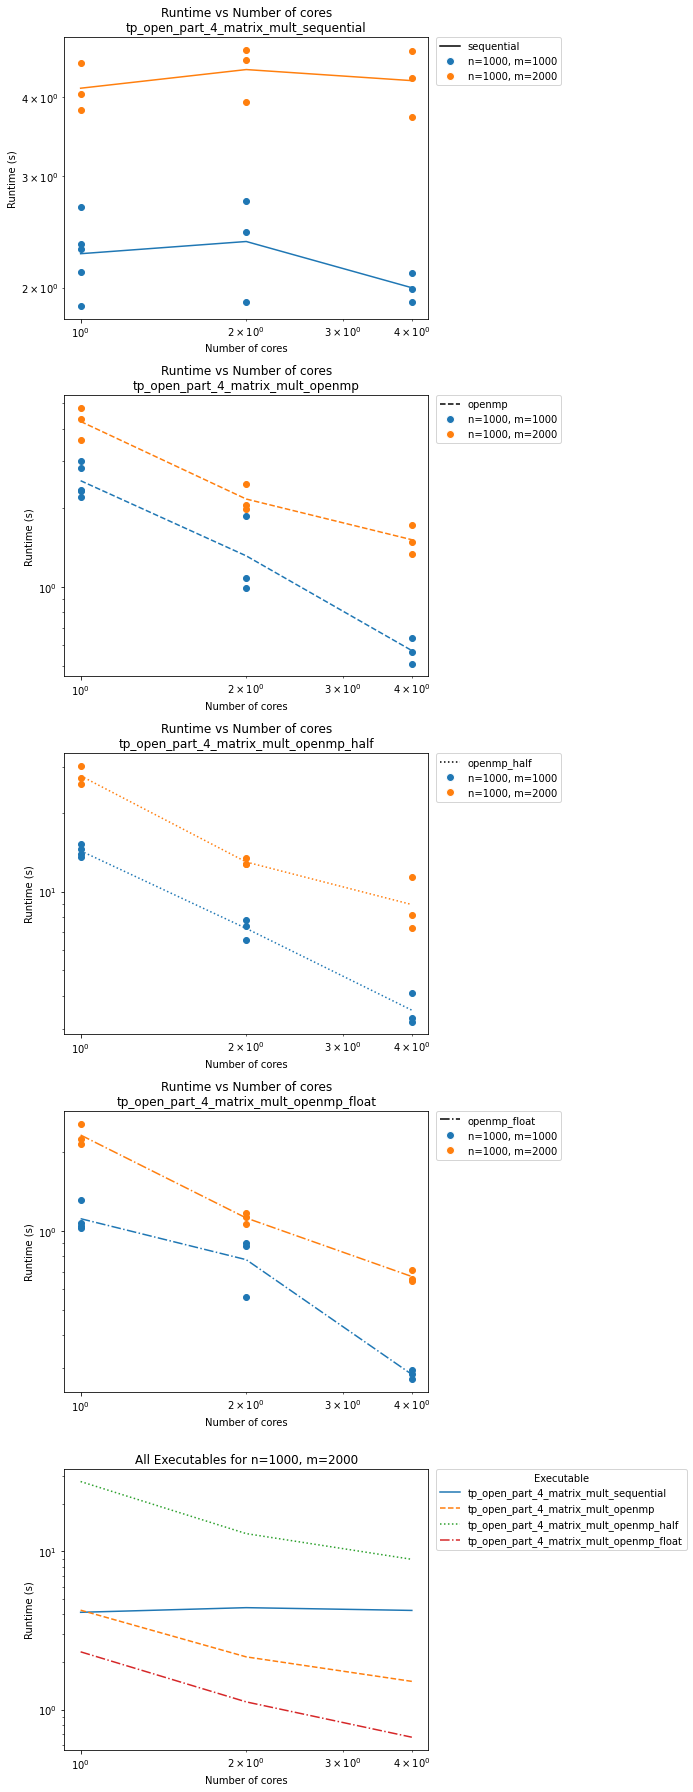

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Lecture du fichier CSV Part 4 (format: executable,ncore,n,m,runtime)
df = pd.read_csv('./Part_4/stats.csv', header=None,
                 names=['version', 'nbcore', 'n', 'm', 'runtime'],
                 dtype={'version': str, 'nbcore': int, 'n': int, 'm': int, 'runtime': float})

df.dropna(subset=['runtime'], inplace=True)
df.reset_index(drop=True, inplace=True)

# Création de la colonne nm pour le couple (n, m)
df['nm'] = list(zip(df['n'], df['m']))

# Mapping de couleurs pour chaque couple (n, m)
unique_nm = sorted(df['nm'].unique())  # Utiliser (n, m) au lieu de 'n' seul
cmap = plt.get_cmap('tab10')
colors_nm = {nm: cmap(i % cmap.N) for i, nm in enumerate(unique_nm)}

# Subplots : un par exécutable + un dernier récapitulatif
fig, axes = plt.subplots(nrows=len(executables) + 1, ncols=1, figsize=(8, 5 * (len(executables) + 1)))
if len(executables) == 1:
    axes = [axes]

# Styles de ligne pour chaque exécutable
linestyles = ['solid', 'dashed', 'dotted', 'dashdot', (0, (3, 1, 1, 1))]

# Tracer chaque exécutable
for idx, executable in enumerate(executables):
    ax = axes[idx]
    for nm in unique_nm:  # Filtrer par couple (n, m)
        df_plot = df[(df['nm'] == nm) & (df['version'] == executable)]  # Filtrer par (n, m) et 'version'
        if df_plot.empty:
            continue
        mean_stats = df_plot.groupby(['nm', 'version', 'nbcore']).mean().reset_index()
        ls = linestyles[idx] if idx < len(linestyles) else 'solid'
        ax.plot(mean_stats['nbcore'], mean_stats['runtime'], linestyle=ls, color=colors_nm[nm])
        ax.scatter(df_plot['nbcore'], df_plot['runtime'], color=colors_nm[nm])

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of cores')
    ax.set_ylabel('Runtime (s)')
    ax.set_title(f'Runtime vs Number of cores\n{executable}')

    # Légende par couple (n, m)
    nm_patches = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_nm[nm], markersize=8, label=f'n={nm[0]}, m={nm[1]}')
        for nm in unique_nm
    ]
    version_handle = plt.Line2D([0], [0], linestyle=ls, color='black',
                                label=executable.replace('tp_open_part_4_matrix_mult_', ''))
    ax.legend(handles=[version_handle] + nm_patches, loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

# Dernier subplot : tracer tous les exécutables pour un couple (n, m) choisi (ici le dernier couple (n, m))
ax_all_executables = axes[-1]
nm_to_plot = unique_nm[-1] if unique_nm else None

if nm_to_plot is not None:
    for executable in executables:
        df_plot = df[(df['nm'] == nm_to_plot) & (df['version'] == executable)]  # Filtrer par (n, m)
        if df_plot.empty:
            continue
        mean_stats = df_plot.groupby(['nm', 'version', 'nbcore']).mean().reset_index()
        ls = linestyles[executables.index(executable)] if executables.index(executable) < len(linestyles) else 'solid'
        ax_all_executables.plot(mean_stats['nbcore'], mean_stats['runtime'], linestyle=ls, label=executable)

    ax_all_executables.set_xscale('log')
    ax_all_executables.set_yscale('log')
    ax_all_executables.set_xlabel('Number of cores')
    ax_all_executables.set_ylabel('Runtime (s)')
    ax_all_executables.set_title(f'All Executables for n={nm_to_plot[0]}, m={nm_to_plot[1]}')
    ax_all_executables.legend(title='Executable', loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

# Ajuster l'agencement des subplots
plt.tight_layout()
plt.subplots_adjust(right=0.75)
plt.show()


### Discussion

Dans ce programme, on effectue la multiplication entre A(N×P) et B(P×M) pour obtenir C(N×M). Dans ce programme Python, on exécute les programmes pour des valeurs de N et M différentes, avec P fixé à 1000.

Cette partie ressemble beaucoup à la partie 3 dans le sens où il y a un programme séquentiel et 3 autres programmes parallèles. Les deuxième, troisième et quatrième graphiques, qui représentent les 3 programmes parallèles, montrent que la multiplication de matrices plus grandes prend plus de temps que la multiplication de petites matrices. Le deuxième point important est que plus le nombre de cœurs augmente, moins le temps d'exécution est long, car les calculs sont répartis entre les cœurs.

On remarque que pour le premier graphique, le programme a un temps d'exécution plus important pour la multiplication de grandes matrices, mais le temps reste le même lorsqu'on change le nombre de cœurs. Cela est dû au fait que c'est un programme séquentiel, donc il utilise toujours un seul cœur.

Dans le dernier graphique, on peut identifier la différence entre les trois types de programmes parallèles :
- 'tp_open_part_4_matrix_mult_openmp' utilise le type double pour les coefficients de la matrice,
- 'tp_open_part_4_matrix_mult_openmp_half' utilise le half.cpp fourni sur Moodle,
- 'tp_open_part_4_matrix_mult_openmp_float' utilise le float.

Le graphique montre les résultats pour n=1000 et m=2000. On observe que le temps d'exécution avec le float est plus court qu'avec le double, ce qui est logique, car le float est codé sur 32 bits, alors que le double l'est sur 64 bits. Par conséquent, on effectue le calcul sur un nombre de bits moins important, ce qui améliore la performance, mais avec une perte de précision lorsque l'on utilise le float.

Le half prend plus de temps que le double, car il bénéficie de certaines optimisations matérielles, alors que le fichier half.cpp est un fichier implémenté en C++, ce qui entraîne des conversions vers le float et le double, ce qui fait perdre son intérêt.